# Task for Today  

***

## Financial Distress Prediction  

Given *data about various companies*, let's try to predict a given company's **financial distress level**.

We will use a linear regression model and a gradient boosting model to make our predictions.

# Getting Started

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/financial-distress/Financial Distress.csv


In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
import xgboost as xgb

from sklearn.metrics import r2_score

In [3]:
data = pd.read_csv('/kaggle/input/financial-distress/Financial Distress.csv')

In [4]:
data

,Company,Time,Financial Distress,x1,x2,x3,x4,x5,x6,x7,...,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83
0,1,1,0.010636,1.2810,0.022934,0.87454,1.21640,0.060940,0.188270,0.52510,...,85.437,27.07,26.102,16.000,16.0,0.2,22,0.060390,30,49
1,1,2,-0.455970,1.2700,0.006454,0.82067,1.00490,-0.014080,0.181040,0.62288,...,107.090,31.31,30.194,17.000,16.0,0.4,22,0.010636,31,50
2,1,3,-0.325390,1.0529,-0.059379,0.92242,0.72926,0.020476,0.044865,0.43292,...,120.870,36.07,35.273,17.000,15.0,-0.2,22,-0.455970,32,51
3,1,4,-0.566570,1.1131,-0.015229,0.85888,0.80974,0.076037,0.091033,0.67546,...,54.806,39.80,38.377,17.167,16.0,5.6,22,-0.325390,33,52
4,2,1,1.357300,1.0623,0.107020,0.81460,0.83593,0.199960,0.047800,0.74200,...,85.437,27.07,26.102,16.000,16.0,0.2,29,1.251000,7,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3667,422,10,0.438020,2.2605,0.202890,0.16037,0.18588,0.175970,0.198400,2.22360,...,100.000,100.00,100.000,17.125,14.5,-7.0,37,0.436380,4,41
3668,422,11,0.482410,1.9615,0.216440,0.20095,0.21642,0.203590,0.189870,1.93820,...,91.500,130.50,132.400,20.000,14.5,-16.0,37,0.438020,5,42
3669,422,12,0.500770,1.7099,0.207970,0.26136,0.21399,0.193670,0.183890,1.68980,...,87.100,175.90,178.100,20.000,14.5,-20.2,37,0.482410,6,43
3670,422,13,0.611030,1.5590,0.185450,0.30728,0.19307,0.172140,0.170680,1.53890,...,92.900,203.20,204.500,22.000,22.0,6.4,37,0.500770,7,44


# Preprocessing

In [5]:
print("Total missing values:", data.isna().sum().sum())

Total missing values: 0


In [6]:
data = data.drop(['Company'], axis=1)

In [7]:
def onehot_encode(df, column, prefix):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=prefix)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [8]:
data = onehot_encode(data, column='x80', prefix='x80')

In [9]:
data

,Time,Financial Distress,x1,x2,x3,x4,x5,x6,x7,x8,...,x80_28,x80_29,x80_30,x80_31,x80_32,x80_33,x80_34,x80_35,x80_36,x80_37
0,1,0.010636,1.2810,0.022934,0.87454,1.21640,0.060940,0.188270,0.52510,0.018854,...,0,0,0,0,0,0,0,0,0,0
1,2,-0.455970,1.2700,0.006454,0.82067,1.00490,-0.014080,0.181040,0.62288,0.006423,...,0,0,0,0,0,0,0,0,0,0
2,3,-0.325390,1.0529,-0.059379,0.92242,0.72926,0.020476,0.044865,0.43292,-0.081423,...,0,0,0,0,0,0,0,0,0,0
3,4,-0.566570,1.1131,-0.015229,0.85888,0.80974,0.076037,0.091033,0.67546,-0.018807,...,0,0,0,0,0,0,0,0,0,0
4,1,1.357300,1.0623,0.107020,0.81460,0.83593,0.199960,0.047800,0.74200,0.128030,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3667,10,0.438020,2.2605,0.202890,0.16037,0.18588,0.175970,0.198400,2.22360,1.091500,...,0,0,0,0,0,0,0,0,0,1
3668,11,0.482410,1.9615,0.216440,0.20095,0.21642,0.203590,0.189870,1.93820,1.000100,...,0,0,0,0,0,0,0,0,0,1
3669,12,0.500770,1.7099,0.207970,0.26136,0.21399,0.193670,0.183890,1.68980,0.971860,...,0,0,0,0,0,0,0,0,0,1
3670,13,0.611030,1.5590,0.185450,0.30728,0.19307,0.172140,0.170680,1.53890,0.960570,...,0,0,0,0,0,0,0,0,0,1


In [10]:
print("Non-numeric columns:", len(data.select_dtypes('object').columns))

Non-numeric columns: 0


# Splitting/Scaling

In [11]:
y = data['Financial Distress'].copy()
X = data.drop('Financial Distress', axis=1).copy()

In [12]:
X.set_index('Time',inplace=True)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=100)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=100)

In [14]:
X_test

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x80_28,x80_29,x80_30,x80_31,x80_32,x80_33,x80_34,x80_35,x80_36,x80_37
Time,,,,,,,,,,,,,,,,,,,,,
5,1.50470,0.288160,0.46392,0.95407,0.321570,0.144810,0.76480,0.302030,0.537530,0.340480,...,0,0,0,0,0,0,0,0,0,0
12,1.01590,0.047697,0.79940,1.55680,0.199600,0.011958,0.80270,0.030638,0.237770,0.029099,...,0,0,0,0,0,0,0,0,0,0
14,0.80819,0.397320,0.33138,0.72538,0.393040,-0.062344,0.44713,0.547740,0.594240,0.435600,...,0,0,0,0,0,0,0,0,0,0
2,1.14380,0.161910,0.74043,0.84386,0.216910,0.098180,0.48027,0.191870,0.623780,0.146150,...,0,0,0,0,0,0,0,0,0,0
5,1.54090,0.077979,0.61804,0.12841,0.095830,0.311640,0.55810,0.607240,0.204160,0.009069,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,1.03850,0.045462,0.84047,0.63739,0.062467,0.016744,0.32740,0.071325,0.284970,0.007977,...,0,0,0,0,0,0,0,0,0,0
8,1.27670,0.022455,0.69075,0.66496,0.058534,0.110860,0.56470,0.033769,0.072613,0.124080,...,0,0,0,0,0,0,0,0,0,0
1,1.03400,0.072733,0.63699,0.63227,0.100680,0.018165,0.35583,0.115030,0.200360,0.004341,...,0,1,0,0,0,0,0,0,0,0


# Linear Regression

In [15]:
lin_model = LinearRegression()
lin_model.fit(X_train.values, y_train.values)

# Predict the model
pred = lin_model.predict(X_test)
from sklearn.metrics import mean_squared_error as MSE 
# RMSE Computation
rmse = np.sqrt(MSE(y_test, pred))
print("RMSE : % f" %(rmse))

RMSE :  169.062271


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


# XG Boost Model

In [16]:
xgb_r = xgb.XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, seed = 123)
xgb_r.fit(X_train.values, y_train.values)
  
# Predict the model
pred = xgb_r.predict(X_test.values)
from sklearn.metrics import mean_squared_error as MSE 
# RMSE Computation
rmse = np.sqrt(MSE(y_test, pred))
print("RMSE : % f" %(rmse))

[18:23:14] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
RMSE :  3.982698


In [17]:
pip install dynamask

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 991.6 kB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 27.3 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [18]:
X_test

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x80_28,x80_29,x80_30,x80_31,x80_32,x80_33,x80_34,x80_35,x80_36,x80_37
Time,,,,,,,,,,,,,,,,,,,,,
5,1.50470,0.288160,0.46392,0.95407,0.321570,0.144810,0.76480,0.302030,0.537530,0.340480,...,0,0,0,0,0,0,0,0,0,0
12,1.01590,0.047697,0.79940,1.55680,0.199600,0.011958,0.80270,0.030638,0.237770,0.029099,...,0,0,0,0,0,0,0,0,0,0
14,0.80819,0.397320,0.33138,0.72538,0.393040,-0.062344,0.44713,0.547740,0.594240,0.435600,...,0,0,0,0,0,0,0,0,0,0
2,1.14380,0.161910,0.74043,0.84386,0.216910,0.098180,0.48027,0.191870,0.623780,0.146150,...,0,0,0,0,0,0,0,0,0,0
5,1.54090,0.077979,0.61804,0.12841,0.095830,0.311640,0.55810,0.607240,0.204160,0.009069,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,1.03850,0.045462,0.84047,0.63739,0.062467,0.016744,0.32740,0.071325,0.284970,0.007977,...,0,0,0,0,0,0,0,0,0,0
8,1.27670,0.022455,0.69075,0.66496,0.058534,0.110860,0.56470,0.033769,0.072613,0.124080,...,0,0,0,0,0,0,0,0,0,0
1,1.03400,0.072733,0.63699,0.63227,0.100680,0.018165,0.35583,0.115030,0.200360,0.004341,...,0,1,0,0,0,0,0,0,0,0


In [19]:
from dynamask.fit.TSX.utils import load_data
import torch
import torch.utils.data as utils
from torch.utils.data import DataLoader
from dynamask.attribution.perturbation import FadeMovingAverage
from  dynamask.attribution.perturbation import GaussianBlur
from torch.nn.functional import mse_loss
from dynamask.attribution.mask import Mask
#from dynamask.models.models import StateClassifier
from dynamask.attribution.mask_group import MaskGroup

def blackbox(x):
    out=xgb_r.predict(x.detach().cpu().numpy())
    return torch.tensor(out)
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('GPU')
else:
    device = torch.device('cpu')
    print('CPU')
pert = GaussianBlur(device)
mask = MaskGroup(pert, device)
areas = [0.1, .25,0.35,0.45,0.55,0.65,0.66,0.70,0.80]


CPU


In [20]:
mask.fit(torch.tensor(X_test.values, dtype=torch.float), f=blackbox, loss_function=mse_loss, size_reg_factor_init=0.01,area_list=areas,learning_rate=2.5, size_reg_factor_dilation=10000, initial_mask_coeff=0.5, n_epoch=800, momentum=1.0, time_reg_factor=2)


Epoch 1/800: error = 1.11 ; size regulator = 0.25 ; time regulator = 0 ; time elapsed = 36.8 s
Epoch 2/800: error = 1.11 ; size regulator = 0.25 ; time regulator = 2.17e-10 ; time elapsed = 34.5 s
Epoch 3/800: error = 1.11 ; size regulator = 0.25 ; time regulator = 1.17e-07 ; time elapsed = 38 s
Epoch 4/800: error = 1.11 ; size regulator = 0.25 ; time regulator = 1.12e-07 ; time elapsed = 36.2 s
Epoch 5/800: error = 1.11 ; size regulator = 0.25 ; time regulator = 1.85e-07 ; time elapsed = 32.9 s
Epoch 6/800: error = 1.11 ; size regulator = 0.25 ; time regulator = 1.82e-07 ; time elapsed = 35 s
Epoch 7/800: error = 1.11 ; size regulator = 0.25 ; time regulator = 2.82e-07 ; time elapsed = 35.4 s
Epoch 8/800: error = 1.11 ; size regulator = 0.25 ; time regulator = 2.85e-07 ; time elapsed = 32.9 s
Epoch 9/800: error = 1.11 ; size regulator = 0.25 ; time regulator = 3.4e-07 ; time elapsed = 34.9 s
Epoch 10/800: error = 1.11 ; size regulator = 0.25 ; time regulator = 3.47e-07 ; time elapsed 

The mask of area 0.8 is extremal with error = 0.294.


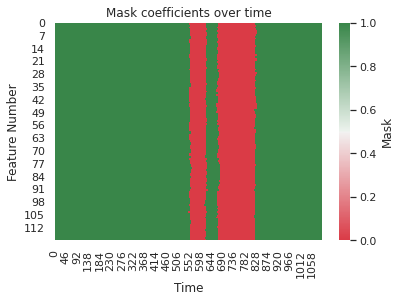

In [21]:
masks = mask.get_extremal_mask(threshold=0.3)
masks.plot_mask(smooth= False, sigma=2.0)

# Data Every Day  

This notebook is featured on Data Every Day, a YouTube series where I train models on a new dataset each day.  

***

Check it out!  
https://youtu.be/AOF5g8TVsGc